In [94]:
import os
import ast
import wfdb
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", DEVICE)

OUT_DIR = "mae_pretraining"
os.makedirs(OUT_DIR, exist_ok=True)

Using device: cuda


In [95]:
path = "/kaggle/input/datasets/tirtho5282/a-large-publicly-available-electrocardiography/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3"
sampling_rate = 100

Y = pd.read_csv(os.path.join(path, "ptbxl_database.csv"), index_col="ecg_id")
Y['scp_codes'] = Y['scp_codes'].apply(lambda x: ast.literal_eval(x))

def load_raw_data(df, sampling_rate, path):
    file_col = 'filename_lr' if sampling_rate == 100 else 'filename_hr'
    data = [wfdb.rdsamp(os.path.join(path, f))[0] for f in df[file_col]]
    return np.array(data)

print("Loading ECG signals...")
X = load_raw_data(Y, sampling_rate, path)
print("Shape:", X.shape)

Loading ECG signals...
Shape: (21799, 1000, 12)


In [96]:
import torch

X_tensor = torch.tensor(X, dtype=torch.float32).permute(0,2,1)

print(X_tensor.shape)

torch.Size([21799, 12, 1000])


In [97]:
mean = X_tensor.mean(dim=(0,2), keepdim=True)
std  = X_tensor.std(dim=(0,2), keepdim=True) + 1e-6

X_tensor = (X_tensor - mean) / std

In [98]:
class ECGDataset(Dataset):
    def __init__(self, X):
        self.X = X
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx]

train_loader = DataLoader(
    ECGDataset(X_tensor),
    batch_size=64,
    shuffle=True
)

In [99]:
class BasicBlock1D(nn.Module):
    def __init__(self, in_c, out_c, stride=1):
        super().__init__()
        self.conv1 = nn.Conv1d(in_c, out_c, 3, stride, 1, bias=False)
        self.bn1 = nn.BatchNorm1d(out_c)
        self.conv2 = nn.Conv1d(out_c, out_c, 3, 1, 1, bias=False)
        self.bn2 = nn.BatchNorm1d(out_c)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_c != out_c:
            self.shortcut = nn.Sequential(
                nn.Conv1d(in_c, out_c, 1, stride, bias=False),
                nn.BatchNorm1d(out_c)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        return F.relu(out + self.shortcut(x))


class ResNet1D(nn.Module):
    def __init__(self, in_channels=12):
        super().__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv1d(in_channels, 64, 7, 2, 3, bias=False)
        self.bn1 = nn.BatchNorm1d(64)

        self.layer1 = self._make_layer(64, 2, 1)
        self.layer2 = self._make_layer(128, 2, 2)
        self.layer3 = self._make_layer(256, 2, 2)
        self.layer4 = self._make_layer(512, 2, 2)

    def _make_layer(self, planes, blocks, stride):
        layers = [BasicBlock1D(self.in_planes, planes, stride)]
        self.in_planes = planes
        for _ in range(1, blocks):
            layers.append(BasicBlock1D(self.in_planes, planes))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        return x

In [100]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MAE_ResNet1D(nn.Module):
    def __init__(self, in_channels=12, mask_ratio=0.25):
        super().__init__()
        self.mask_ratio = mask_ratio

        self.encoder = ResNet1D(in_channels=in_channels)

        self.decoder = nn.Sequential(
            nn.Conv1d(512, 512, 3, padding=1),
            nn.GELU(),
            nn.Conv1d(512, 256, 3, padding=1),
            nn.GELU(),
            nn.Conv1d(256, in_channels, 3, padding=1)
        )

    def random_mask(self, x):
        B, C, L = x.shape
        mask = torch.rand(B, 1, L, device=x.device)
        mask = (mask > self.mask_ratio).float()
        return mask

    def forward(self, x):

        mask = self.random_mask(x)
        x_masked = x * mask

        z = self.encoder(x_masked)
        z_up = F.interpolate(z, size=x.shape[-1], mode="linear", align_corners=False)

        x_rec = self.decoder(z_up)

        loss = ((x_rec - x) ** 2 * (1 - mask)).mean()

        return loss

In [101]:
model = MAE_ResNet1D(in_channels=12).to(DEVICE)
print(type(model))

<class '__main__.MAE_ResNet1D'>


In [102]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100)
scaler = torch.amp.GradScaler("cuda")

In [103]:
batch = next(iter(train_loader)).to(DEVICE)
loss = model(batch)

print("Loss shape:", loss.shape)

Loss shape: torch.Size([])


In [104]:
EPOCHS = 100

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0

    for batch in train_loader:
        batch = batch.to(DEVICE)

        optimizer.zero_grad()

        with torch.amp.autocast("cuda"):
            loss = model(batch)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item()

    scheduler.step()

    print(f"Epoch {epoch+1}: MAE Loss = {total_loss:.6f}")

Epoch 1: MAE Loss = 55.012057
Epoch 2: MAE Loss = 43.284938
Epoch 3: MAE Loss = 39.914029
Epoch 4: MAE Loss = 39.118118
Epoch 5: MAE Loss = 36.232935
Epoch 6: MAE Loss = 34.830003
Epoch 7: MAE Loss = 34.456257
Epoch 8: MAE Loss = 33.399362
Epoch 9: MAE Loss = 31.857392
Epoch 10: MAE Loss = 32.972533
Epoch 11: MAE Loss = 32.165806
Epoch 12: MAE Loss = 31.930745
Epoch 13: MAE Loss = 28.928026
Epoch 14: MAE Loss = 29.803879
Epoch 15: MAE Loss = 28.509938
Epoch 16: MAE Loss = 29.346524
Epoch 17: MAE Loss = 31.223514
Epoch 18: MAE Loss = 31.919121
Epoch 19: MAE Loss = 29.798954
Epoch 20: MAE Loss = 28.148778
Epoch 21: MAE Loss = 30.042859
Epoch 22: MAE Loss = 28.849799
Epoch 23: MAE Loss = 28.689480
Epoch 24: MAE Loss = 26.299867
Epoch 25: MAE Loss = 29.876650
Epoch 26: MAE Loss = 27.892810
Epoch 27: MAE Loss = 27.738393
Epoch 28: MAE Loss = 31.837985
Epoch 29: MAE Loss = 27.276895
Epoch 30: MAE Loss = 26.947592
Epoch 31: MAE Loss = 26.537667
Epoch 32: MAE Loss = 28.229011
Epoch 33: MAE Los

In [105]:
torch.save(
    model.encoder.state_dict(),
    os.path.join(OUT_DIR, "mae_encoder.pth")
)
print("Encoder saved.")

Encoder saved.


In [106]:
from sklearn.model_selection import train_test_split

indices = np.arange(len(X_tensor))
train_idx, val_idx = train_test_split(
    indices, test_size=0.1, random_state=42
)

train_loader = DataLoader(
    ECGDataset(X_tensor[train_idx]),
    batch_size=64,
    shuffle=True
)

val_loader = DataLoader(
    ECGDataset(X_tensor[val_idx]),
    batch_size=64,
    shuffle=False
)

In [107]:
import time

best_val = float("inf")
history = {"train_loss": [], "val_loss": []}

EPOCHS = 100

for epoch in range(EPOCHS):

    start = time.time()

    # -------- TRAIN --------
    model.train()
    train_loss = 0

    for batch in train_loader:
        batch = batch.to(DEVICE)

        optimizer.zero_grad()

        with torch.amp.autocast("cuda"):
            loss = model(batch)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        train_loss += loss.item()

    train_loss /= len(train_loader)

    # -------- VALIDATION --------
    model.eval()
    val_loss = 0

    with torch.no_grad():
        for batch in val_loader:
            batch = batch.to(DEVICE)
            with torch.amp.autocast("cuda"):
                loss = model(batch)
            val_loss += loss.item()

    val_loss /= len(val_loader)

    scheduler.step()

    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)

    epoch_time = time.time() - start

    print(f"Epoch {epoch+1}/{EPOCHS} | "
          f"Train: {train_loss:.6f} | "
          f"Val: {val_loss:.6f} | "
          f"Time: {epoch_time:.1f}s")

    # -------- Save Best Model --------
    if val_loss < best_val:
        best_val = val_loss
        torch.save(model.state_dict(), "mae_best.pth")

Epoch 1/100 | Train: 0.059542 | Val: 0.058057 | Time: 46.7s
Epoch 2/100 | Train: 0.059332 | Val: 0.058333 | Time: 46.6s
Epoch 3/100 | Train: 0.059382 | Val: 0.058736 | Time: 46.6s
Epoch 4/100 | Train: 0.059128 | Val: 0.058613 | Time: 46.6s
Epoch 5/100 | Train: 0.059432 | Val: 0.058465 | Time: 46.6s
Epoch 6/100 | Train: 0.059505 | Val: 0.059180 | Time: 46.6s
Epoch 7/100 | Train: 0.059579 | Val: 0.058466 | Time: 46.6s
Epoch 8/100 | Train: 0.059223 | Val: 0.059343 | Time: 46.6s
Epoch 9/100 | Train: 0.059732 | Val: 0.058724 | Time: 46.6s
Epoch 10/100 | Train: 0.059600 | Val: 0.057103 | Time: 46.6s
Epoch 11/100 | Train: 0.059238 | Val: 0.059272 | Time: 46.6s
Epoch 12/100 | Train: 0.059381 | Val: 0.059531 | Time: 46.6s
Epoch 13/100 | Train: 0.059729 | Val: 0.060108 | Time: 46.6s
Epoch 14/100 | Train: 0.059517 | Val: 0.058507 | Time: 46.6s
Epoch 15/100 | Train: 0.059620 | Val: 0.058552 | Time: 46.6s
Epoch 16/100 | Train: 0.059537 | Val: 0.059771 | Time: 46.6s
Epoch 17/100 | Train: 0.059675 | 

In [108]:
torch.save(model.state_dict(), "mae_last.pth")
print("Saved final model.")

Saved final model.


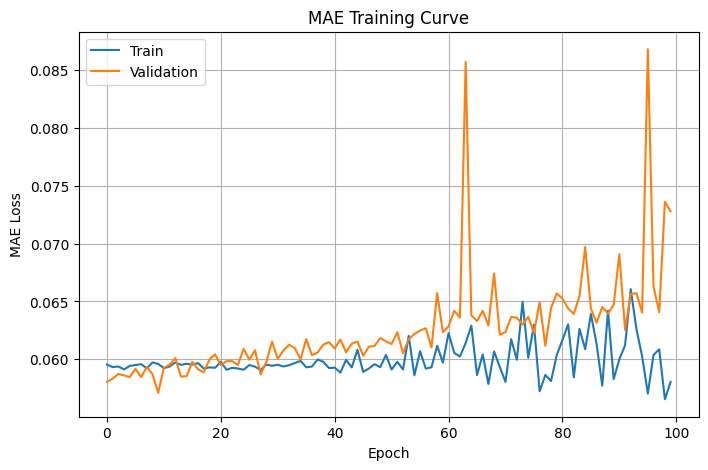

In [109]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(history["train_loss"], label="Train")
plt.plot(history["val_loss"], label="Validation")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("MAE Loss")
plt.title("MAE Training Curve")
plt.grid(True)
plt.show()

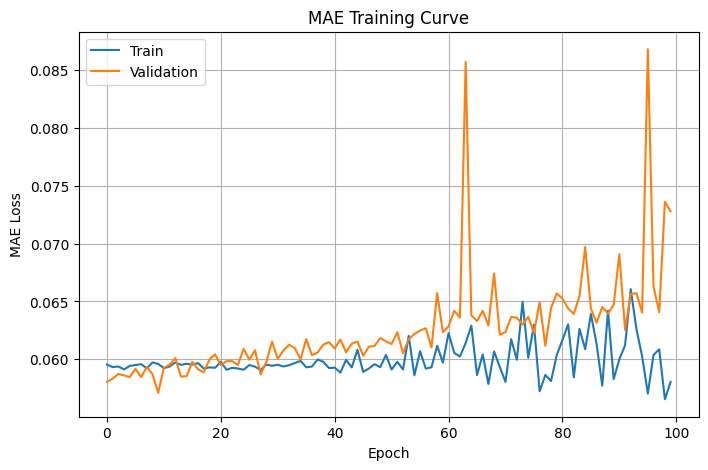

In [110]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(history["train_loss"], label="Train")
plt.plot(history["val_loss"], label="Validation")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("MAE Loss")
plt.title("MAE Training Curve")
plt.grid(True)
plt.show()

In [111]:
def extract_features(X_input, batch_size=64):

    model.encoder.eval()
    feats = []

    with torch.no_grad():
        for i in range(0, len(X_input), batch_size):
            batch = X_input[i:i+batch_size].to(DEVICE)
            z = model.encoder(batch)
            pooled = F.adaptive_avg_pool1d(z, 1).squeeze(-1)
            feats.append(pooled.cpu())

    return torch.cat(feats, dim=0)

In [112]:
torch.save(model.encoder.state_dict(), "mae_encoder.pth")

In [135]:
encoder = ResNet1D(in_channels=12)
encoder.load_state_dict(torch.load("mae_encoder.pth", map_location=DEVICE))
encoder = encoder.to(DEVICE)
encoder.eval()

ResNet1D(
  (conv1): Conv1d(12, 64, kernel_size=(7,), stride=(2,), padding=(3,), bias=False)
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock1D(
      (conv1): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
      (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
      (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock1D(
      (conv1): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
      (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
      (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_sta

In [136]:
def extract_features(X_tensor, batch_size=64):

    features = []
    encoder.eval()

    with torch.no_grad():
        for i in range(0, len(X_tensor), batch_size):
            batch = X_tensor[i:i+batch_size].to(DEVICE)
            z = encoder(batch)  # (B, 512, L)
            pooled = F.adaptive_avg_pool1d(z, 1).squeeze(-1)  # (B, 512)
            features.append(pooled.cpu())

    return torch.cat(features, dim=0).numpy()

In [137]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_feat = extract_features(X_train_tensor)
X_val_feat   = extract_features(X_val_tensor)

In [138]:
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

models = {
    "LogisticRegression": LogisticRegression(max_iter=5000),
    "SVM": SVC(),
    "RandomForest": RandomForestClassifier(n_estimators=200)
}

y_train_np = y_train_tensor.cpu().numpy()
y_val_np   = y_val_tensor.cpu().numpy()

for name, clf in models.items():
    clf.fit(X_train_feat, y_train_np)
    preds = clf.predict(X_val_feat)
    acc = accuracy_score(y_val_np, preds)
    print(f"\n{name} Accuracy: {acc:.4f}")
    print(classification_report(y_val_np, preds))


LogisticRegression Accuracy: 0.7708
              precision    recall  f1-score   support

           0       0.84      0.64      0.72       136
           1       0.65      0.30      0.41        43
           2       0.69      0.56      0.62       203
           3       0.80      0.93      0.86       726
           4       0.68      0.60      0.64       192

    accuracy                           0.77      1300
   macro avg       0.73      0.61      0.65      1300
weighted avg       0.76      0.77      0.76      1300


SVM Accuracy: 0.7392
              precision    recall  f1-score   support

           0       0.94      0.46      0.61       136
           1       0.00      0.00      0.00        43
           2       0.77      0.47      0.59       203
           3       0.73      0.97      0.83       726
           4       0.71      0.51      0.59       192

    accuracy                           0.74      1300
   macro avg       0.63      0.48      0.52      1300
weighted avg      

Feature shape: (11695, 512)
Classes: [0 1 2 3 4]


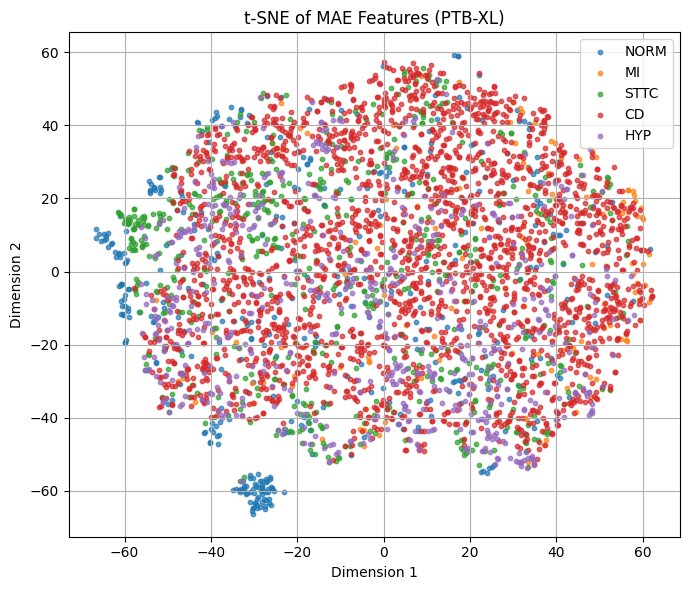

In [153]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# -----------------------------
# 1️⃣ Define features + labels
# -----------------------------
X_feat = X_train_feat
y_feat = y_train_tensor.cpu().numpy()

print("Feature shape:", X_feat.shape)
print("Classes:", np.unique(y_feat))

# -----------------------------
# 2️⃣ Optional: use subset (faster t-SNE)
# -----------------------------
subset = 4000  # change to None if you want full dataset
if subset is not None:
    X_feat = X_feat[:subset]
    y_feat = y_feat[:subset]

# -----------------------------
# 3️⃣ PCA -> 50D (important for stability)
# -----------------------------
pca = PCA(n_components=50, random_state=42)
X_pca = pca.fit_transform(X_feat)

# -----------------------------
# 4️⃣ t-SNE
# -----------------------------
tsne = TSNE(
    n_components=2,
    perplexity=30,
    learning_rate=200,
    max_iter=1000,
    random_state=42
)

X_tsne = tsne.fit_transform(X_pca)

# -----------------------------
# 5️⃣ Plot with class names
# -----------------------------
label_map = {
    0: "NORM",
    1: "MI",
    2: "STTC",
    3: "CD",
    4: "HYP"
}

plt.figure(figsize=(7,6))

for cls in np.unique(y_feat):
    idx = y_feat == cls
    plt.scatter(
        X_tsne[idx, 0],
        X_tsne[idx, 1],
        s=10,
        alpha=0.7,
        label=label_map[cls]
    )

plt.title("t-SNE of MAE Features (PTB-XL)")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [155]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, f1_score

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

class MLP(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.4),

            nn.Linear(512, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.3),

            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        return self.net(x)

In [156]:
Xtr = torch.tensor(X_train_feat, dtype=torch.float32)
Ytr = torch.tensor(y_train_tensor.cpu().numpy(), dtype=torch.long)

Xva = torch.tensor(X_val_feat, dtype=torch.float32)
Yva = torch.tensor(y_val_tensor.cpu().numpy(), dtype=torch.long)

train_loader = DataLoader(TensorDataset(Xtr, Ytr), batch_size=64, shuffle=True)
val_loader   = DataLoader(TensorDataset(Xva, Yva), batch_size=64)

In [158]:
model_mlp = MLP(input_dim=512, num_classes=5).to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model_mlp.parameters(), lr=1e-3)

EPOCHS = 100

for epoch in range(EPOCHS):
    model_mlp.train()
    total_loss = 0

    for xb, yb in train_loader:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)

        optimizer.zero_grad()
        logits = model_mlp(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    # Validation
    model_mlp.eval()
    preds, labels = [], []

    with torch.no_grad():
        for xb, yb in val_loader:
            xb = xb.to(DEVICE)
            out = model_mlp(xb).argmax(1).cpu()
            preds.append(out)
            labels.append(yb)

    preds = torch.cat(preds).numpy()
    labels = torch.cat(labels).numpy()

    acc = accuracy_score(labels, preds)
    f1  = f1_score(labels, preds, average="macro")

    print(f"Epoch {epoch+1}: Acc={acc:.4f} | Macro-F1={f1:.4f}")

Epoch 1: Acc=0.5423 | Macro-F1=0.4125
Epoch 2: Acc=0.5854 | Macro-F1=0.5387
Epoch 3: Acc=0.7446 | Macro-F1=0.5890
Epoch 4: Acc=0.7431 | Macro-F1=0.5832
Epoch 5: Acc=0.6646 | Macro-F1=0.5174
Epoch 6: Acc=0.5662 | Macro-F1=0.4839
Epoch 7: Acc=0.7369 | Macro-F1=0.6138
Epoch 8: Acc=0.6892 | Macro-F1=0.5133
Epoch 9: Acc=0.7469 | Macro-F1=0.6160
Epoch 10: Acc=0.7431 | Macro-F1=0.5683
Epoch 11: Acc=0.6454 | Macro-F1=0.5841
Epoch 12: Acc=0.7292 | Macro-F1=0.5338
Epoch 13: Acc=0.7346 | Macro-F1=0.5115
Epoch 14: Acc=0.7338 | Macro-F1=0.5156
Epoch 15: Acc=0.7000 | Macro-F1=0.5507
Epoch 16: Acc=0.7562 | Macro-F1=0.6419
Epoch 17: Acc=0.7162 | Macro-F1=0.5186
Epoch 18: Acc=0.7238 | Macro-F1=0.5877
Epoch 19: Acc=0.7800 | Macro-F1=0.6548
Epoch 20: Acc=0.7500 | Macro-F1=0.5505
Epoch 21: Acc=0.7323 | Macro-F1=0.5334
Epoch 22: Acc=0.7400 | Macro-F1=0.6099
Epoch 23: Acc=0.7177 | Macro-F1=0.6097
Epoch 24: Acc=0.7238 | Macro-F1=0.6237
Epoch 25: Acc=0.7338 | Macro-F1=0.5509
Epoch 26: Acc=0.7885 | Macro-F1=0.

In [159]:
!pip install xgboost

In [160]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report

xgb = XGBClassifier(
    n_estimators=400,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="multi:softprob",
    num_class=5,
    eval_metric="mlogloss",
    random_state=42
)

xgb.fit(X_train_feat, y_train_tensor.cpu().numpy())

preds = xgb.predict(X_val_feat)

print("XGBoost Accuracy:", accuracy_score(y_val_tensor.cpu().numpy(), preds))
print(classification_report(y_val_tensor.cpu().numpy(), preds))

XGBoost Accuracy: 0.7623076923076924
              precision    recall  f1-score   support

           0       0.88      0.61      0.72       136
           1       0.71      0.12      0.20        43
           2       0.75      0.52      0.62       203
           3       0.77      0.94      0.85       726
           4       0.68      0.58      0.62       192

    accuracy                           0.76      1300
   macro avg       0.76      0.55      0.60      1300
weighted avg       0.76      0.76      0.74      1300



In [162]:
# MLP probabilities
model_mlp.eval()
mlp_probs = []

with torch.no_grad():
    for xb, _ in val_loader:
        xb = xb.to(DEVICE)
        probs = torch.softmax(model_mlp(xb), dim=1).cpu()
        mlp_probs.append(probs)

mlp_probs = torch.cat(mlp_probs).numpy()

# XGBoost probabilities
xgb_probs = xgb.predict_proba(X_val_feat)

In [163]:
fusion_features = np.concatenate([mlp_probs, xgb_probs], axis=1)

In [164]:
from sklearn.linear_model import LogisticRegression

fusion_model = LogisticRegression(max_iter=5000)
fusion_model.fit(fusion_features, y_val_tensor.cpu().numpy())

fusion_preds = fusion_model.predict(fusion_features)

print("Fusion Accuracy:", accuracy_score(y_val_tensor.cpu().numpy(), fusion_preds))

Fusion Accuracy: 0.79
